<a href="https://colab.research.google.com/github/harshmangalamv/2001CE24_2022/blob/main/Copy_of_vgg16_top_modified_batch_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
# !pip install keras-preprocessing
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import os

# Load data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
MPimg_path = '/content/drive/MyDrive/MPs Data/MPimg'
DB_from_others_path = '/content/drive/MyDrive/MPs Data/Other_Resources'

from re import M
# we need to traverse the folder and store all the images (with [img, type]) of one group (beads, fibres, fragments) in one folder
# after that splitting the whole data into train, test and validation is done
# NOTE: while traversing, extract the type of mp image also

MPimg_beads_path = MPimg_path + "/beads"
MPimg_fibres_path = MPimg_path + "/fibers"
MPimg_fragments_path = MPimg_path + "/fragments"

classification_classes = ['beads', 'fibers', 'fragments']

beads = []
fibers = []
fragments = []

# beads 0, fibers 1, fragments 2

for classes in classification_classes:
  path_ = MPimg_path + '/' + classes
  for image_name in os.listdir(path_):
    img_path = path_ + '/' + image_name
    if classes == 'beads':
      beads.append([img_path, 0])
    elif classes == 'fibers':
      fibers.append([img_path, 1])
    elif classes == 'fragments':
      fragments.append([img_path, 2])

# paths for different categories in other resources images
# DB1
other_resources_db1 = "/content/drive/MyDrive/MPs Data/Other_Resources/dataset/dataset1/[datasets_subset]_Exp2"
other_resources_db1_beads = "/content/drive/MyDrive/MPs Data/Other_Resources/dataset/dataset1/[datasets_subset]_Exp2/bead/image"
other_resources_db1_fibers_1 = "/content/drive/MyDrive/MPs Data/Other_Resources/dataset/dataset1/[datasets_subset]_Exp2/fibre_1/image"
other_resources_db1_fibers_1crop = "/content/drive/MyDrive/MPs Data/Other_Resources/dataset/dataset1/[datasets_subset]_Exp2/fibre_1crop/image"
other_resources_db1_fibers_2 = "/content/drive/MyDrive/MPs Data/Other_Resources/dataset/dataset1/[datasets_subset]_Exp2/fibre_2/image"
other_resources_db1_fibers_2crop = "/content/drive/MyDrive/MPs Data/Other_Resources/dataset/dataset1/[datasets_subset]_Exp2/fibre_2crop/image"
other_resources_db1_fibers_fragment_1 = "/content/drive/MyDrive/MPs Data/Other_Resources/dataset/dataset1/[datasets_subset]_Exp2/fragment_1/image"
other_resources_db1_fibers_fragment_2 = "/content/drive/MyDrive/MPs Data/Other_Resources/dataset/dataset1/[datasets_subset]_Exp2/fragment_2/image"

def file_paths_creater(path_, store_, store_name):
  for image_name in os.listdir(path_):
    img_path = path_ + '/' + image_name
    store_.append([img_path, store_name])

file_paths_creater(other_resources_db1_beads, beads, 0)
file_paths_creater(other_resources_db1_fibers_1, fibers, 1)
file_paths_creater(other_resources_db1_fibers_1crop, fibers, 1)
file_paths_creater(other_resources_db1_fibers_2, fibers, 1)
file_paths_creater(other_resources_db1_fibers_2crop, fibers, 1)
file_paths_creater(other_resources_db1_fibers_fragment_1, fragments, 2)
file_paths_creater(other_resources_db1_fibers_fragment_2, fragments, 2)

# SET IMAGE WIDTH AND OTHER CONSTANTS
# Defining ratios for image width and height
img_width = 224
img_height = 224

# Define the ratios for train, test, and validation sets
train_ratio = 0.8
test_ratio = 0.10
valid_ratio = 0.10

#### PREPARING DATA
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

full_data = []
for data in beads:
  full_data.append(data)

for data in fibers:
  full_data.append(data)

for data in fragments:
  full_data.append(data)

print("--------------------")
print("total images: ", len(full_data))
print("--------------------")

# Assuming full_data is your numpy array containing file paths and label names

# Extract file paths and labels
file_paths = [data[0] for data in full_data]  # First column contains file paths
labels = [data[1] for data in full_data]       # Second column contains label names

# Convert label names to numerical labels
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
numerical_labels = np.array([label_to_index[label] for label in labels])


Mounted at /content/drive
--------------------
total images:  812
--------------------


In [2]:
# Split the data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, numerical_labels, test_size=valid_ratio+test_ratio, train_size=train_ratio, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + valid_ratio), train_size=valid_ratio/(test_ratio + valid_ratio), random_state=42)

print(len(file_paths), len(X_train), len(X_test), len(X_val))

812 649 82 81


In [3]:
# Function to load and preprocess images
def load_and_preprocess_images(file_paths, img_width, img_height):
    images = []
    for path in file_paths:
        # Load image from file path
        img = Image.open(path)
        # Resize image to desired dimensions
        img = img.resize((img_width, img_height))
        # Convert image to numpy array
        img_array = np.array(img)
        # Check if image array is grayscale (2D) or color (3D)
        if len(img_array.shape) == 2:  # Grayscale image
            # Convert grayscale image to RGB by repeating the single channel
            img_array = np.stack((img_array,) * 3, axis=-1)
        # Check if the image has four channels
        elif len(img_array.shape) == 3 and img_array.shape[2] == 4:
            # Convert the image to RGB mode (discard the alpha channel)
            img_array = img_array[:, :, :3]
        # Preprocess input according to the requirements of your model
        img_array = preprocess_input(img_array)
        img_array = np.array(img_array)
        # Append preprocessed image array to the list
        images.append(img_array)

    return np.array(images)

    # return images

# Load and preprocess images for training set
X_train_images = load_and_preprocess_images(X_train, img_width, img_height)
# Load and preprocess images for test set
X_test_images = load_and_preprocess_images(X_test, img_width, img_height)
# # Load and preprocess images for validation set
X_val_images = load_and_preprocess_images(X_val, img_width, img_height)

In [80]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    # rescale=1./255,
    cval = 0)

# VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_to_index), activation='softmax'))  # Number of classes is the length of unique labels

from keras.layers import LeakyReLU

# Add custom layers on top of the base model
# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.01))  # Using Leaky ReLU with alpha=0.01
# model.add(Dense(128))
# model.add(LeakyReLU(alpha=0.01))  # Using Leaky ReLU with alpha=0.01
# model.add(Dense(len(label_to_index), activation='softmax'))  # Number of classes is the length of unique labels



# Compile the model
# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9)
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule, momentum=0.9)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

one_hot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = one_hot_encoder.transform(y_test.reshape(-1, 1))

batch_size = 16

# Data generators
train_generator = train_datagen.flow(
    x = X_train_images,
    y = y_train,
    batch_size = batch_size
)

validation_generator = train_datagen.flow(
    x = X_val_images,
    y = y_val,
    batch_size = batch_size
)

test_generator = train_datagen.flow(
    x = X_test_images,
    y = y_test,
    batch_size = batch_size
)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [81]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch = len(X_train) // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps = len(X_test) // batch_size,
    callbacks=[early_stopping])

#  ACCIDENTALLY RAN THIS SNIPPET, BUT RESULTS DOWNWARDS ARE TRUE

Epoch 1/100
40/40 [==============================] - 12s 263ms/step - loss: 1.2114 - accuracy: 0.4534 - val_loss: 0.9699 - val_accuracy: 0.5375
Epoch 2/100
40/40 [==============================] - 10s 257ms/step - loss: 0.6996 - accuracy: 0.6793 - val_loss: 0.7010 - val_accuracy: 0.7250
Epoch 3/100
40/40 [==============================] - 10s 261ms/step - loss: 0.5410 - accuracy: 0.7852 - val_loss: 0.6552 - val_accuracy: 0.7125
Epoch 4/100
40/40 [==============================] - 10s 251ms/step - loss: 0.4477 - accuracy: 0.8452 - val_loss: 0.5431 - val_accuracy: 0.8250
Epoch 5/100
40/40 [==============================] - 10s 258ms/step - loss: 0.3905 - accuracy: 0.8752 - val_loss: 0.5000 - val_accuracy: 0.8375
Epoch 6/100
40/40 [==============================] - 10s 245ms/step - loss: 0.3446 - accuracy: 0.8847 - val_loss: 0.4920 - val_accuracy: 0.8250
Epoch 7/100
40/40 [==============================] - 9s 227ms/step - loss: 0.3157 - accuracy: 0.8957 - val_loss: 0.4405 - val_accuracy: 

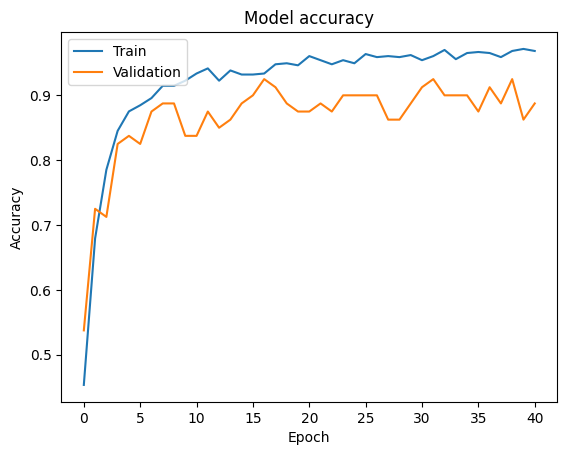

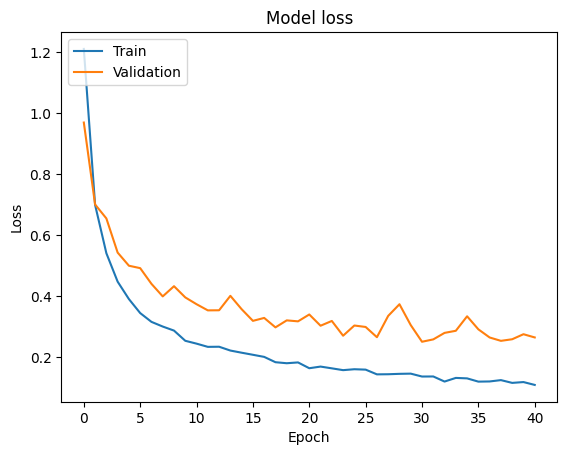

In [82]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [83]:
# Access training and validation metrics from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print or plot the metrics
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)


Training Accuracy: [0.4533965289592743, 0.6793048977851868, 0.7851500511169434, 0.8451817035675049, 0.8751974701881409, 0.8846761584281921, 0.8957346081733704, 0.9146919250488281, 0.9146919250488281, 0.9225908517837524, 0.9336493015289307, 0.9415481686592102, 0.9225908517837524, 0.9383886456489563, 0.9320695400238037, 0.9320695400238037, 0.9336493015289307, 0.9478672742843628, 0.9494470953941345, 0.9462875127792358, 0.9605055451393127, 0.9541864395141602, 0.9478672742843628, 0.9541864395141602, 0.9494470953941345, 0.9636650681495667, 0.958925724029541, 0.9605055451393127, 0.958925724029541, 0.9620853066444397, 0.9541864395141602, 0.9605055451393127, 0.9699841737747192, 0.9557662010192871, 0.9652448892593384, 0.9668246507644653, 0.9652448892593384, 0.958925724029541, 0.9684044122695923, 0.971563994884491, 0.9684044122695923]
Validation Accuracy: [0.5375000238418579, 0.7250000238418579, 0.7124999761581421, 0.824999988079071, 0.8374999761581421, 0.824999988079071, 0.875, 0.887499988079071

3/3 [==============================] - 0s 146ms/step


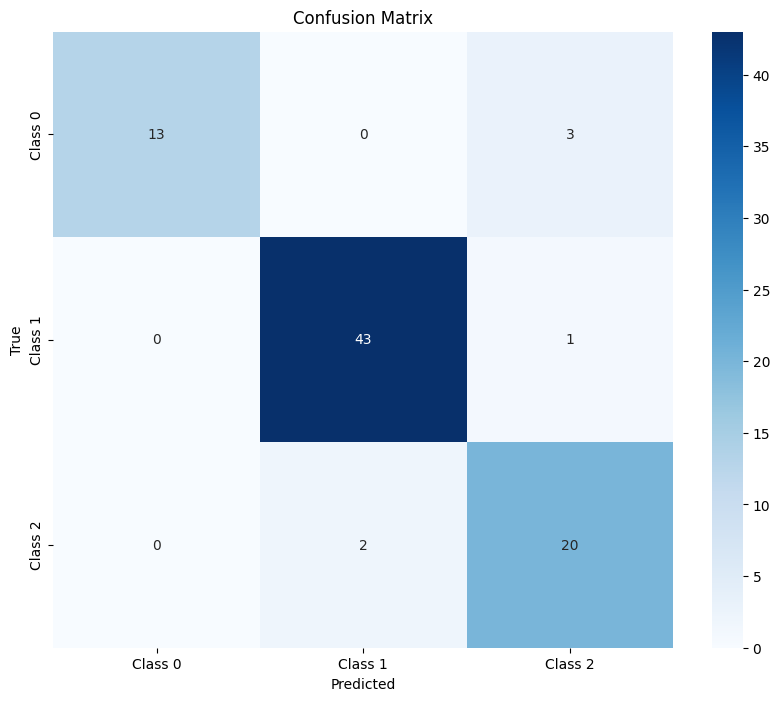

In [84]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for test images
y_pred = np.argmax(model.predict(X_test_images), axis=-1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as per your requirement
print("Precision:", precision)

# Compute recall
recall = recall_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as per your requirement
print("Recall:", recall)

# Compute F1-score
f1 = f1_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as per your requirement
print("F1-score:", f1)


Accuracy: 0.926829268292683
Precision: 0.9296296296296297
Recall: 0.899621212121212
F1-score: 0.9108030254535654


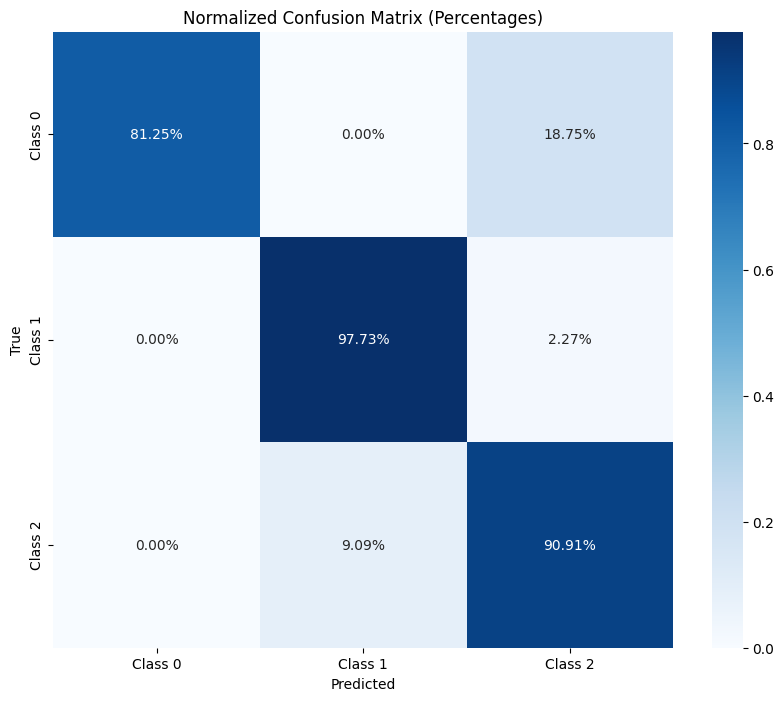

In [86]:
# Normalize confusion matrix to show percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize along the true label axis

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Percentages)')
plt.show()


In [87]:
import cv2
import numpy as np

# Preprocess the input image
def preprocess_image(path):

    img = Image.open(path)
    # Resize image to desired dimensions
    img = img.resize((img_width, img_height))
    # Convert image to numpy array
    img_array = np.array(img)
    # Check if image array is grayscale (2D) or color (3D)
    if len(img_array.shape) == 2:  # Grayscale image
        # Convert grayscale image to RGB by repeating the single channel
        img_array = np.stack((img_array,) * 3, axis=-1)
    # Check if the image has four channels
    elif len(img_array.shape) == 3 and img_array.shape[2] == 4:
        # Convert the image to RGB mode (discard the alpha channel)
        img_array = img_array[:, :, :3]
    # Preprocess input according to the requirements of your model
    img_array = preprocess_input(img_array)
    img_array = np.array(img_array)
    return img_array


In [88]:
def make_predictions(input_img_path):
  # Make predictions using the trained model from the history object
  input_image = preprocess_image(input_image_path)

  # Make predictions on the input image
  predictions = model.predict(np.expand_dims(input_image, axis=0))

  # Get the predicted class label
  predicted_class = np.argmax(predictions)

  # Load and display the input image
  input_image = cv2.imread(input_image_path)
  input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
  plt.imshow(input_image)
  plt.axis('off')
  plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
  plt.show()

1/1 [==============================] - 0s 19ms/step


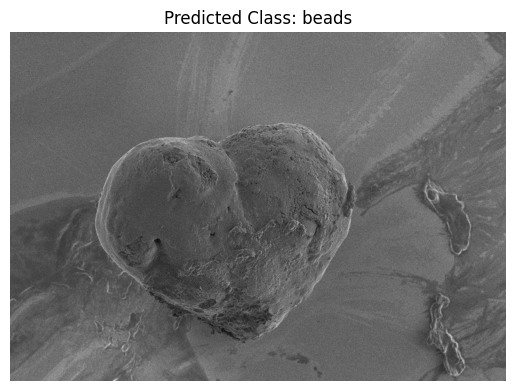

In [89]:
# Make predictions using the trained model from the history object
input_image_path = other_resources_db1_beads + '/Dove_men_acrylates_copolymer_microbeads_021.png' # Provide the path to your input image

input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 20ms/step


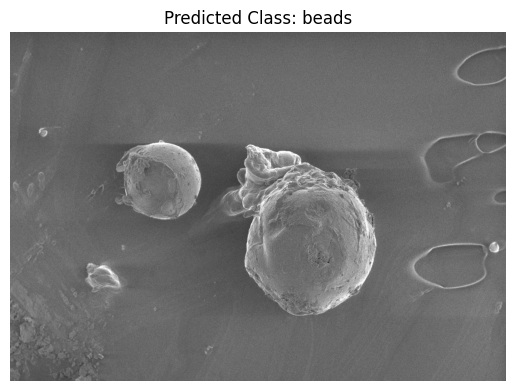

In [90]:
# Make predictions using the trained model from the history object
input_image_path = other_resources_db1_beads + '/Dove_men_acrylates_copolymer_microbeads_063.png' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 32ms/step


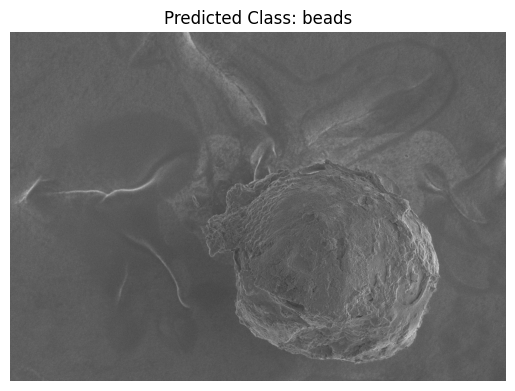

In [91]:
# Make predictions using the trained model from the history object
input_image_path = other_resources_db1_beads + '/Dove_men_acrylates_copolymer_microbeads_058.png' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 31ms/step


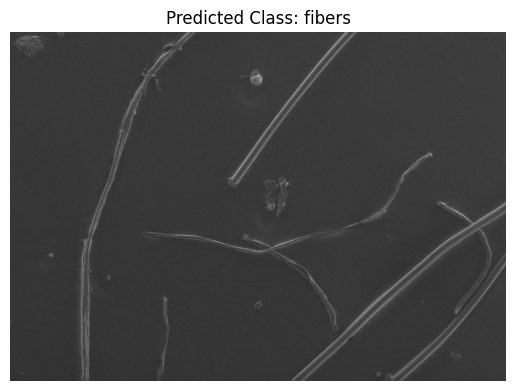

In [92]:
# Make predictions using the trained model from the history object
input_image_path = other_resources_db1_fibers_1 + '/polyester_91.png' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 29ms/step


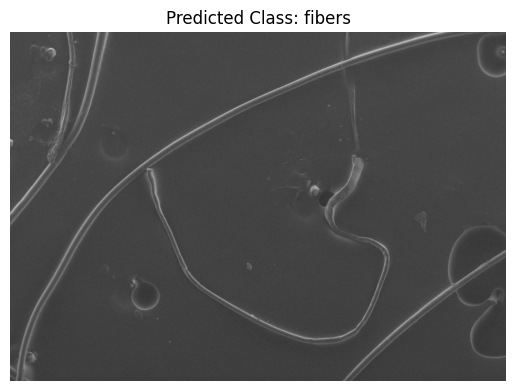

In [93]:
# Make predictions using the trained model from the history object
input_image_path = other_resources_db1_fibers_1 + '/polyester_129.png' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 29ms/step


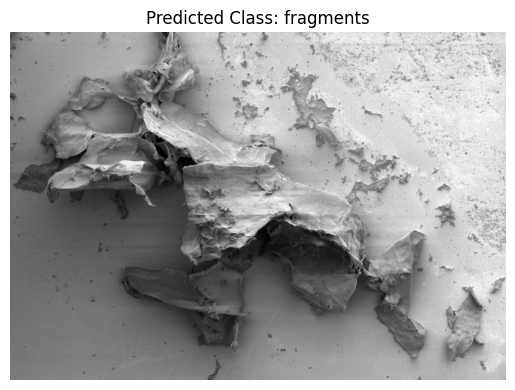

In [94]:
# Make predictions using the trained model from the history object
input_image_path = other_resources_db1_fibers_fragment_2 + '/PS_Isopropyl_Alcohol_Suspension_0063.png' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 33ms/step


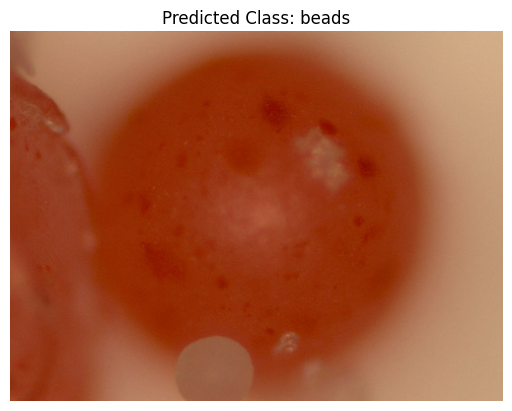

In [95]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_beads_path + '/Beads_PCPs_26.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 36ms/step


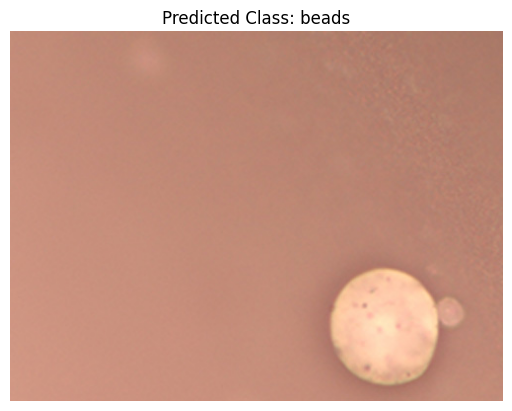

In [96]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_beads_path + '/Beads_PCPs_51.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 27ms/step


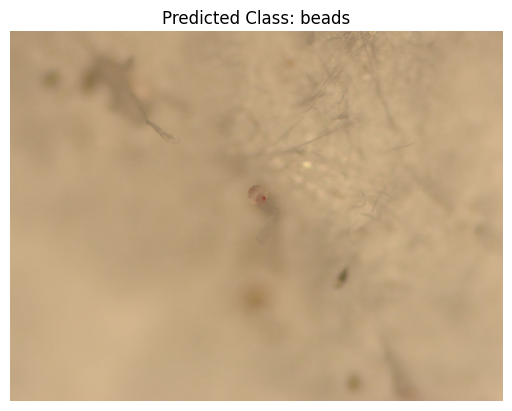

In [97]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_beads_path + '/Beads_wastewater_11.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 19ms/step


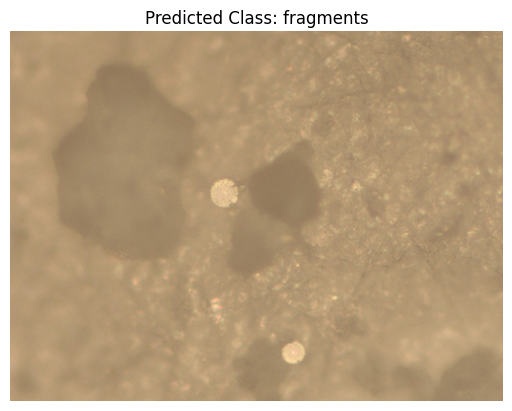

In [98]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_beads_path + '/Beads_PCPs_66.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 19ms/step


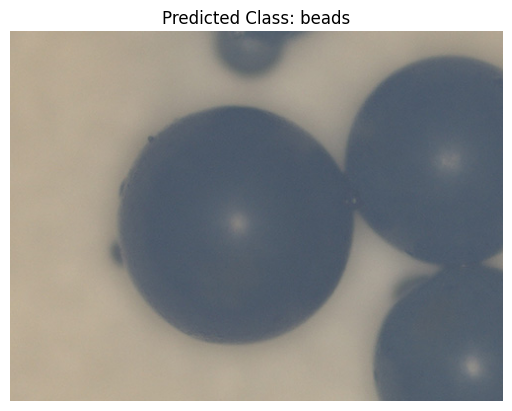

In [99]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_beads_path + '/Beads_PCPs_55.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 21ms/step


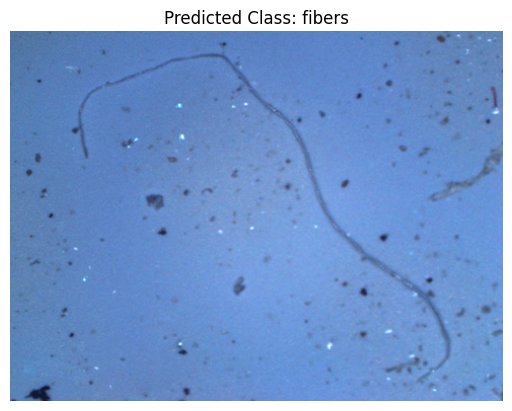

In [100]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_rainwater_3.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 26ms/step


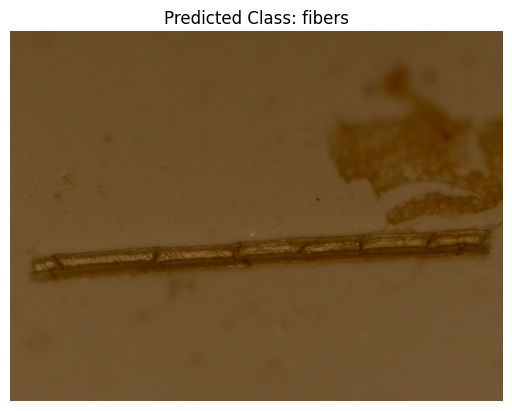

In [101]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_rainwater_41.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 20ms/step


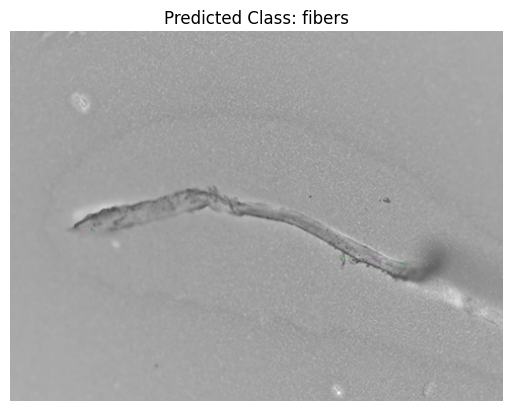

In [102]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_wastewater_21.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 20ms/step


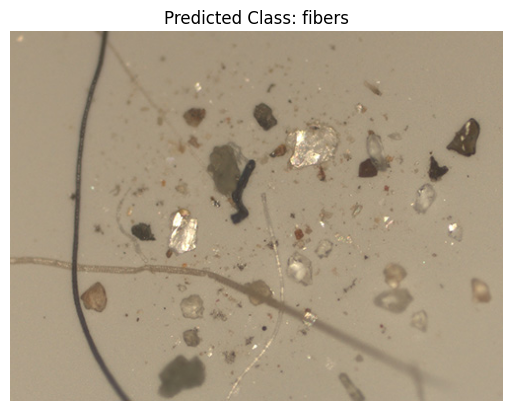

In [103]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_wastewater_33.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 21ms/step


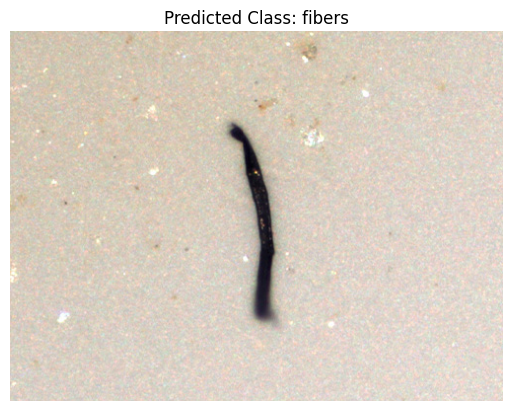

In [104]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_wastewater_19.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 22ms/step


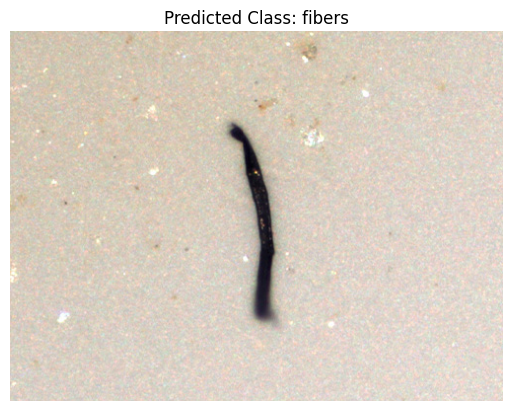

In [105]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_wastewater_19(1).jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 20ms/step


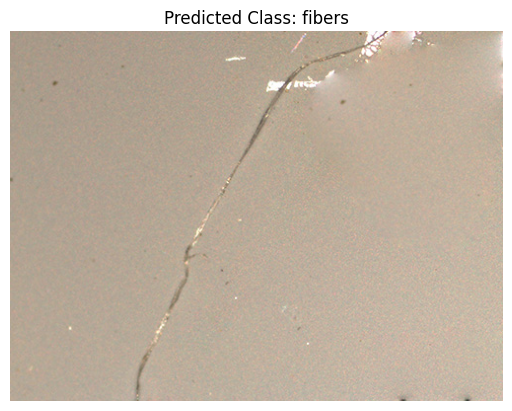

In [106]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_wastewater_18(1).jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 27ms/step


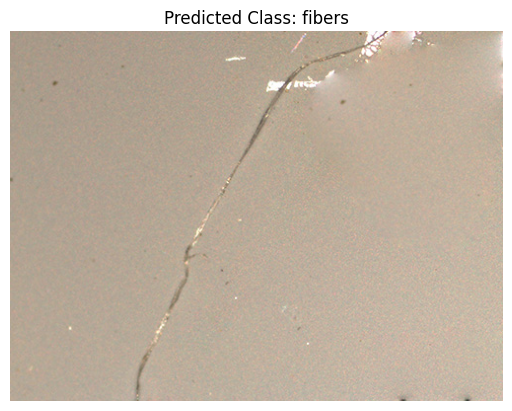

In [107]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_wastewater_18.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 24ms/step


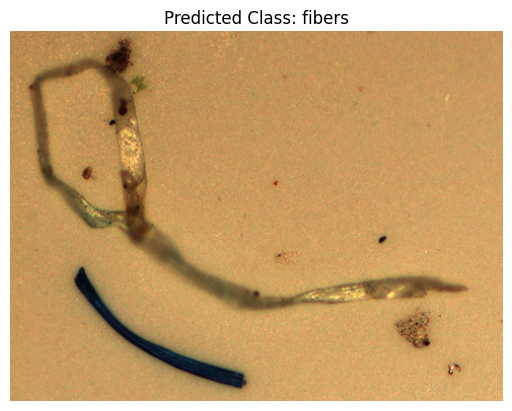

In [108]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fibres_path + '/Fiber_rainwater_17.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 21ms/step


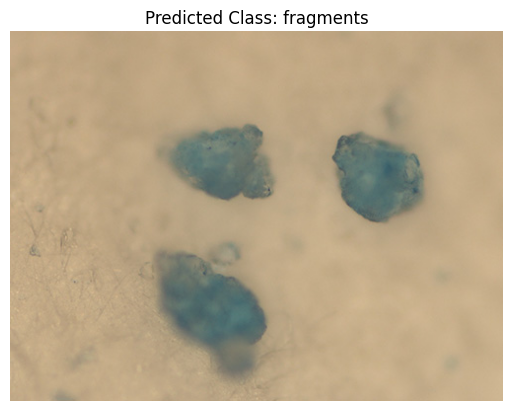

In [109]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fragments_path + '/Fragment_PCPs_2.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()

# W R O N G    C L A S S I F I C A T I O N

1/1 [==============================] - 0s 23ms/step


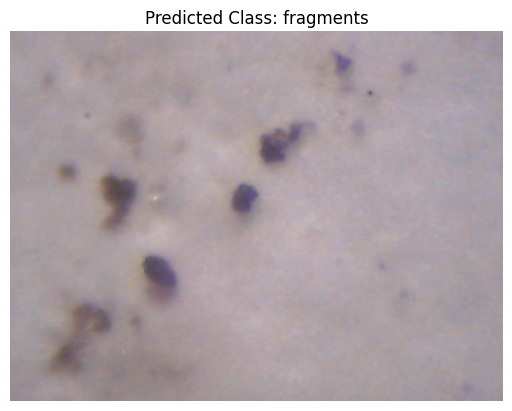

In [110]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fragments_path + '/Fragment_rainwater_9.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()


1/1 [==============================] - 0s 21ms/step


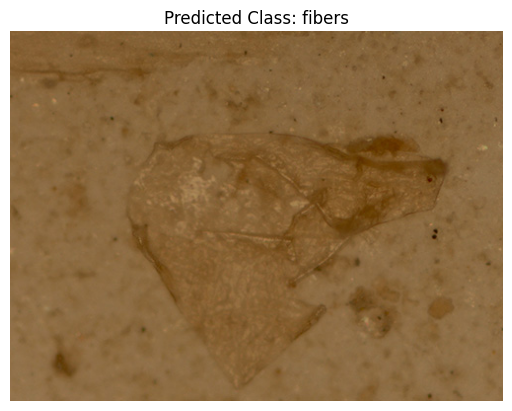

In [111]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fragments_path + '/Fragment_rainwater_15.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()


1/1 [==============================] - 0s 23ms/step


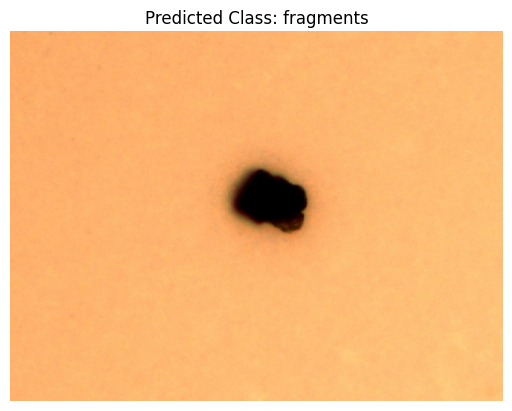

In [112]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fragments_path + '/Fragment_wastewater_4.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()


1/1 [==============================] - 0s 21ms/step


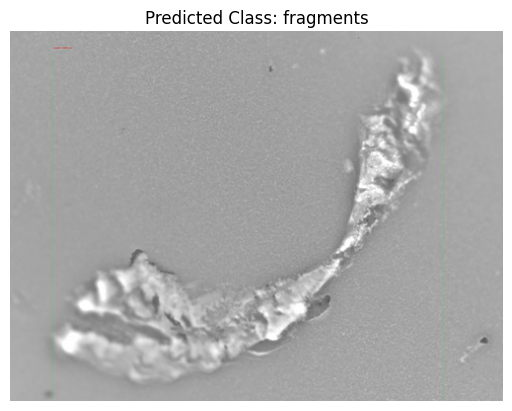

In [113]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fragments_path + '/Fragment_wastewater_14.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()


1/1 [==============================] - 0s 22ms/step


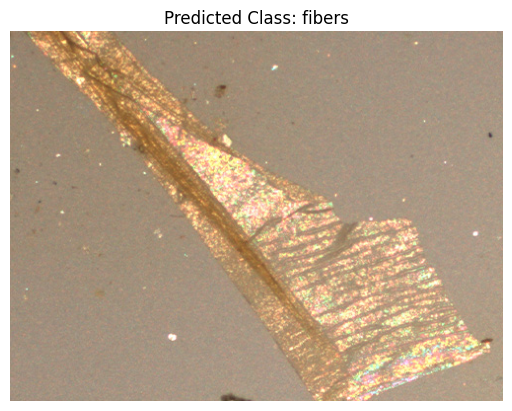

In [114]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fragments_path + '/Fragment_wastewater_50.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()


1/1 [==============================] - 0s 22ms/step


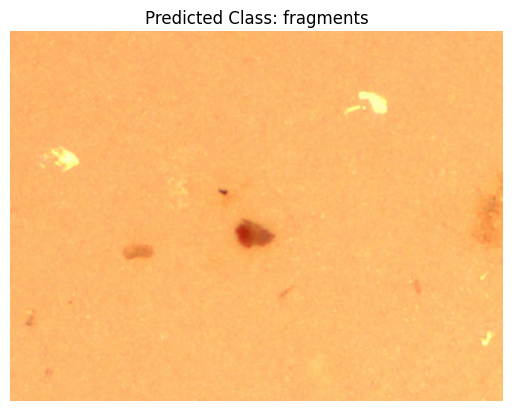

In [115]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fragments_path + '/Fragment_wastewater_97.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()


1/1 [==============================] - 0s 30ms/step


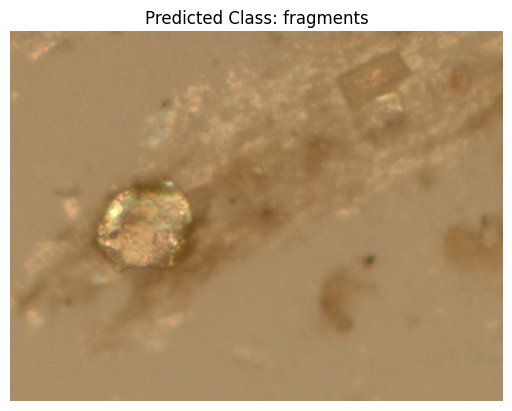

In [116]:
# Make predictions using the trained model from the history object
input_image_path = MPimg_fragments_path + '/Fragment_wastewater_71.jpg' # Provide the path to your input image
input_image = preprocess_image(input_image_path)

# Retrieve the trained model from the history object
model = history.model

# Make predictions on the input image
predictions = model.predict(np.expand_dims(input_image, axis=0))

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Load and display the input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Class: {classification_classes[predicted_class]}')
plt.show()
